# Course Project: Trading Strategy based on PCA

Welcome to your course project. This exercise gives you a hands-on experience to use PCA to:

- construct eigen-portfolios
- implement a measure of market systemic risk
- develop simple trading strategy

**After this assignment you will:**
- Be able to use PCA to construct eigen-portfolios
- Be able to use PCA to calculate a measure of market systemic risk
- Be able to implement and analyze performance of portfolio strategy

Let's get started!

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [pandas](http://pandas.pydata.org/) Python data analysis library
- [pandas](http://scikit-learn.org/stable/) scikit-learn - machine learning in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [9]:
import pandas as pd
import numpy as np
import sklearn.decomposition
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import sys

import matplotlib.pyplot as plt
%matplotlib inline

print("Package Versions:")
print("  scikit-learn: %s" % sklearn.__version__)
print("  tensorflow: %s" % tf.__version__)

sys.path.append("..")
import grading

try:
    import sklearn.model_selection
    import sklearn.linear_model
except:
    print("Looks like an older version of sklearn package")

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

Package Versions:
  scikit-learn: 0.18.2
  tensorflow: 1.10.1
  pandas: 0.19.2


#### Dataset:  daily prices of  stocks from S&P 500 index  ####
For this exercise we will be working with S&P 500 Index stock prices dataset. 
The following cell computes returns based for a subset of S&P 500 index stocks. It starts with stocks price data:

In [12]:
import os
# load dataset

asset_prices = pd.read_csv('/home/jovyan/work/readonly/spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 12
print('Asset prices shape', asset_prices.shape)
asset_prices.iloc[:, :n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,32.9375,33.5625
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,32.3125,33.0000
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,32.5625,33.5000
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,32.5625,33.6875
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,32.5625,33.6250


### Calculate daily log-returns

In [13]:
asset_returns = np.log(asset_prices) - np.log(asset_prices.shift(1))
asset_returns = asset_prices.pct_change(periods=1)
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-28,-0.005480,-0.014185,-0.076134,0.000000,0.034482,-0.081758,-0.005857,-0.015628,-0.024907,-0.049994,-0.018975,-0.016760
2000-01-31,-0.027548,0.002698,0.020912,-0.033352,0.021570,-0.043431,-0.020942,-0.005292,-0.030651,-0.010131,0.007737,0.015152
2000-02-01,0.072710,0.034978,-0.033735,0.031045,0.009593,0.014761,0.048128,0.021281,0.015810,0.036816,0.000000,0.005597
2000-02-02,0.077464,0.033795,-0.014356,0.010037,0.005709,0.097310,-0.017857,-0.020837,-0.054475,0.005920,0.000000,-0.001855
2000-02-03,0.016340,-0.031014,0.045537,-0.006617,0.005670,0.126402,0.098701,0.000000,0.067217,0.035288,0.011516,0.033457


In [14]:
def center_returns(r_df):
    """
    Normalize, i.e. center and divide by standard deviation raw asset returns data

    Arguments:
    r_df -- a pandas.DataFrame of asset returns

    Return:
    normed_df -- normalized returns
    """
    mean_r = r_df.mean(axis=0)
    sd_r = r_df.std(axis=0)
    normed_df = (r_df - mean_r) / sd_r
    return normed_df

In [15]:
normed_r = center_returns(asset_returns)
normed_r.iloc[:, :n_stocks_show].head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP
2000-01-28,-0.190054,-0.513710,-2.714709,-0.049779,2.182933,-2.684131,-0.212461,-0.766996,-1.540731,-1.803947,-1.372991,-0.994169
2000-01-31,-0.898232,0.096888,0.688156,-1.757230,1.355644,-1.438899,-0.720771,-0.279098,-1.891884,-0.391433,0.547298,0.871919
2000-02-01,2.319164,1.264327,-1.227995,1.539597,0.588289,0.451774,1.606541,0.975244,0.948126,1.272129,-0.008894,0.313197
2000-02-02,2.471738,1.221529,-0.548494,0.464060,0.339454,3.133764,-0.616815,-1.012898,-3.348109,0.177340,-0.008894,-0.122594
2000-02-03,0.510174,-1.122380,1.551619,-0.388563,0.336944,4.078966,3.310577,-0.029293,4.090396,1.217955,0.818989,1.942390


Now we are ready to compute Absorption Ratio(AR). We do so by defining a moving look back window over which we collect returns for computing PCA. We start off from the earliest historical data and march forward moving by step_size, which we also choose arbitrary. For each such window we compute PCA and AR, fixing in advance number of components in the enumerator. Specifically, for we use the following hyper-parameters:

#### Part 1 (Implement exponentially-weighted)

**Instructions:**
Implement exponent_weighting function which returns a sequence of $w_j$ as np.array. See below:

Define sequence of $X_j$ where $j \subset [N, 0]$, an integer taking all values in the interval from 0 to N  $$ X_j =  e^{-\frac{log(2)}{H} \times  \space j}$$
where H is half-life which determines the speed of decay, and $log$ is natural log function
Then a sequence of exponentially decaying weights $w_j$ is defined as $$ w_j = \frac{X_j}{ \sum\limits_{j=0}^N X_j } $$

In [16]:
def exponent_weighting(n_periods, half_life = 252):
    """
    Calculate exponentially smoothed normalized (in probability density function sense) weights

    Arguments:
    n_periods -- number of periods, an integer, N in the formula above
    half_life -- half-life, which determines the speed of decay, h in the formula
    
    Return:
    exp_probs -- exponentially smoothed weights, np.array
    """
    
    exp_probs = np.zeros(n_periods) 
   
    x_j = np.exp( (-np.log(2) / half_life) * np.arange(n_periods))
    X = np.sum(np.exp( (-np.log(2) / half_life) * np.arange(n_periods)))
    exp_probs = x_j / X
    
    return exp_probs


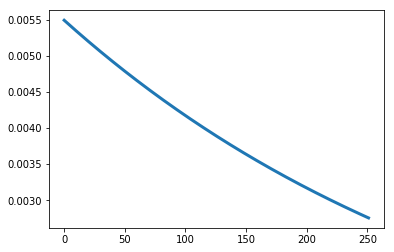

In [17]:
exp_probs = exponent_weighting(252*1)
plt.plot(exp_probs, linewidth=3)

In [19]:
def absorption_ratio(explained_variance, n_components):
    """
    Calculate absorption ratio via PCA. absorption_ratio() is NOT to be used with Auto-Encoder. 
    
    Arguments:
    explained_variance -- 1D np.array of explained variance by each pricincipal component, in descending order
    
    n_components -- an integer, a number of principal components to compute absorption ratio
    
    Return:
    ar -- absorption ratio
    """
    ar = np.sum(explained_variance[:n_components]) / np.sum(explained_variance)
    return ar

#### Part 2 (Implement Linear Auto-Encoder with TensorFlow)

LinearAutoEncoder class has two fully connected layers and no activation functions between the layers.

**Instructions:**
- fill missing code within LinearAutoEncoder class
- in init() method of LinearAutoEncoder setup neural network
    - **self.codings_layer** is a fully connected layer with **n_codings** neurons and no activation function
    - **self.outputs** is a fully connected layer with **n_outputs** neurons and no activation function
    - define loss function as Mean Square Error between the outputs and inputs referenced by **self.X** in the code
    - use AdamOptimizer to optimize model parameters

In [20]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
class LinearAutoEncoder:
    """
    To perform simple PCA, we set activation_fn=None 
    i.e., all neurons are linear and the cost function is the Mean-Square Error (MSE)
    """
    def __init__(self, n_inputs, n_codings, learning_rate=0.01):
        self.learning_rate = learning_rate
        n_outputs = n_inputs
        self.destroy()
        reset_graph()
    
        # the inputs are n_inputs x n_inputs covariance matrices
        self.X = tf.placeholder(tf.float32, shape=[None, n_inputs, n_inputs])
        with tf.name_scope("lin_ae"):
            self.codings_layer = None
            self.outputs = None
            self.codings_layer = fully_connected(self.X, n_codings, activation_fn=None)
            self.outputs = fully_connected(self.codings_layer, n_outputs, activation_fn=None)
        
        with tf.name_scope("loss"):
            self.reconstruction_loss = None
            self.training_op = None
           
            self.reconstruction_loss = tf.reduce_mean(tf.squared_difference(self.X, self.outputs))
            self.training_op = tf.train.AdamOptimizer(learning_rate).minimize(self.reconstruction_loss)  
            self.init = tf.global_variables_initializer()
            
    def destroy(self):
        if hasattr(self, 'sess') and self.sess is not None:
            self.sess.close()
            self.sess = None

    def absorption_ratio(self, test_input):
        """
        Calculate absorption ratio based on already trained model
        """
        if self.outputs is None:
            return test_input, 0.
        
        with self.sess.as_default():  # do not close session
            codings = self.codings_layer.eval(feed_dict={self.X: test_input})

            # calculate variance explained ratio
            result_ = self.outputs.eval(feed_dict={self.X: test_input})
            var_explained = np.sum(np.diag(result_.squeeze())) / np.sum(np.diag(test_input.squeeze()))

        return codings[0, :, :], var_explained
    
    def next_batch(self, X_train, batch_size):
        """
        X_train - np.array of double of size K x N x N, where N is dimensionality of the covariance matrix
        batch_size - an integer, number of training examples to feed through the nwtwork at once
        """
        y_batch = None

        selected_idx = np.random.choice(tuple(range(X_train.shape[0])), size=batch_size)
        X_batch = X_train[selected_idx, :, :]
        return X_batch, y_batch

    def train(self, X_train, X_test, n_epochs=5, batch_size=2, verbose=False):
        """
        train simple auto-encoder network
        :param X_train:
        :param X_test:
        :param n_epochs: number of epochs to use for training the model
        :param batch_size:
        :return:
        """
        if self.outputs is None:
            return X_test, 0.
        
        n_examples = len(X_train)  # number of training examples
        self.sess = tf.Session()
        
        # as_default context manager does not close the session when you exit the context,
        # and you must close the session explicitly.
        with self.sess.as_default():
            self.init.run()
            for epoch in range(n_epochs):
                n_batches = n_examples // min(n_examples, batch_size)
                for _ in range(n_batches):
                    X_batch, y_batch = self.next_batch(X_train, batch_size)
                    self.sess.run(self.training_op, feed_dict={self.X: X_batch})
                
                if verbose:
                    # last covariance matrix from the training sample
                    if X_train.shape[0] == 1:
                        mse_train = self.reconstruction_loss.eval(feed_dict={self.X: X_train})
                    else:
                        mse_train = self.reconstruction_loss.eval(feed_dict={self.X: np.array([X_train[-1, :, :]])})
                    mse_test = self.reconstruction_loss.eval(feed_dict={self.X: X_test})
                    print('Epoch %d. MSE Train %.4f, MSE Test %.4f' % (epoch, mse_train, mse_test))

            # calculate variance explained ratio
            test_input = np.array([X_train[-1, :, :]])
            result_ = self.outputs.eval(feed_dict={self.X: test_input})
            var_explained = np.sum(np.diag(result_.squeeze())) / np.sum(np.diag(test_input.squeeze()))
            # print('Linear Auto-Encoder: variance explained: %.2f' % var_explained)

            codings = self.codings_layer.eval(feed_dict={self.X: X_test})
            # print('Done training linear auto-encoder')

        return codings[0, :, :], var_explained

In [21]:
### GRADED PART (DO NOT EDIT) ###
ix_offset = 1000
stock_tickers = asset_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

step_size = 60
num_samples = 5
lookback_window = 252 * 2   # in (days)
num_assets = len(stock_tickers)
cov_matricies = np.zeros((num_samples, num_assets, num_assets)) # hold training data

# collect training and test data
ik = 0
for ix in range(ix_offset, min(ix_offset + num_samples * step_size, len(normed_r)), step_size):
    ret_frame = normed_r.iloc[ix_offset - lookback_window:ix_offset, :-1]
    print("time index and covariance matrix shape", ix, ret_frame.shape)
    cov_matricies[ik, :, :] = ret_frame.cov()
    ik += 1

# the last covariance matrix determines the absorption ratio
lin_ae = LinearAutoEncoder(n_inputs=num_assets, n_codings=200)
np.array([cov_matricies[-1, :, :]]).shape
lin_codings, test_absorp_ratio = lin_ae.train(cov_matricies[ : int((2/3)*num_samples), :, :],
                                                np.array([cov_matricies[-1, :, :]]),
                                                n_epochs=10, 
                                                batch_size=5)
lin_codings, in_sample_absorp_ratio = lin_ae.absorption_ratio(np.array([cov_matricies[0, :, :]]))
### GRADED PART (DO NOT EDIT) ###

time index and covariance matrix shape 1000 (504, 418)
time index and covariance matrix shape 1060 (504, 418)
time index and covariance matrix shape 1120 (504, 418)
time index and covariance matrix shape 1180 (504, 418)
time index and covariance matrix shape 1240 (504, 418)


In [22]:
### GRADED PART (DO NOT EDIT) ###
part_2=[test_absorp_ratio, in_sample_absorp_ratio]
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)
[test_absorp_ratio, in_sample_absorp_ratio]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.39359208195496026, 0.39359208195496026]

In [23]:
stock_tickers = asset_returns.columns.values[:-1]
assert 'SPX' not in stock_tickers, "By accident included SPX index"

half_life = 252             # in (days)
lookback_window = 252 * 2   # in (days)
num_assets = len(stock_tickers)
step_size = 1          # days : 5 - weekly, 21 - monthly, 63 - quarterly

# require of that much variance to be explained. How many components are needed?
var_threshold = 0.8     

# fix 20% of principal components for absorption ratio calculation. How much variance do they explain?
absorb_comp = int((1 / 5) * num_assets)  

print('Half-life = %d' % half_life)
print('Lookback window = %d' % lookback_window)
print('Step size = %d' % step_size)
print('Variance Threshold = %d' % var_threshold)
print('Number of stocks = %d' % num_assets)
print('Number of principal components = %d' % absorb_comp)

Half-life = 252
Lookback window = 504
Step size = 1
Variance Threshold = 0
Number of stocks = 418
Number of principal components = 83


In [24]:
# indexes date on which to compute PCA
days_offset = 4 * 252
num_days = 6 * 252 + days_offset
pca_ts_index = normed_r.index[list(range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size))]

# allocate arrays for storing absorption ratio
pca_components = np.array([np.nan]*len(pca_ts_index))
absorp_ratio = np.array([np.nan]*len(pca_ts_index))
lae_ar = np.array([np.nan]*len(pca_ts_index))  # absorption ratio computed by Auto-Encoder 

# keep track of covariance matricies as we would need them for training Auto-Encoder
buf_size = 5
cov_matricies = np.zeros((buf_size, num_assets, num_assets))

exp_probs = exponent_weighting(lookback_window, half_life)
assert 'SPX' not in normed_r.iloc[:lookback_window, :-1].columns.values, "By accident included SPX index"

**Instructions:**
- on each loop iteration: 
    - fit PCA to **cov_mat**
    - use fitted pca model to pass values to absorption_ratio(). The result of absorption ratio calculation goes into **absorp_ratio**
    - compute number of principal components it takes to explain at least **var_threshold** of variance. The result of this calculation goes into **pca_components** 

In [25]:
# run the main loop computing PCA and absorption at each step using moving window of returns  
# run this loop using both exponentially weighted returns and equally weighted returns
import time
from sklearn.decomposition import PCA
ik = 0
use_ewm = False
lin_ae = None
time_start = time.time()
for ix in range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size):
    ret_frame = normed_r.iloc[ix - lookback_window:ix, :-1]  # fixed window
    # ret_frame = normed_r.iloc[:ix, :-1]  # ever-growing window
    if use_ewm:
        ret_frame = (ret_frame.T * exp_probs).T
    
    cov_mat = ret_frame.cov()
    circ_idx = ik % buf_size
    cov_matricies[circ_idx, :, :] = cov_mat.values

    if ik == 0 or ik % 21 == 0:
      
        ### fit PCA, compute absorption ratio by calling absorption_ratio()
        ### store result into pca_components for grading
        pca = PCA().fit(cov_mat)
        absorp_ratio[ik] = absorption_ratio(pca.explained_variance_, absorb_comp)
        var_explained = np.cumsum(pca.explained_variance_ratio_)
        pca_components[ik] = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1
      
    else:
        absorp_ratio[ik] = absorp_ratio[ik-1] 
        pca_components[ik] = pca_components[ik-1]
    
    if ik == 0 or ik % 252 == 0:        
        if lin_ae is not None:
            lin_ae.destroy()

        print('Trainging AE', normed_r.index[ix])
        lin_ae = LinearAutoEncoder(cov_mat.shape[0], absorb_comp)
        lin_codings, lae_ar[ik] = lin_ae.train(cov_matricies[:circ_idx + 1, :, :], np.array([cov_mat.values]),batch_size=2)
    else:
        lin_codings, lae_ar[ik] = lin_ae.absorption_ratio(np.array([cov_mat.values]))

    ik += 1
    
print ('Absorption Ratio done! Time elapsed: {} seconds'.format(time.time() - time_start))    
ts_pca_components = pd.Series(pca_components, index=pca_ts_index)
ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)
ts_lae_absorb_ratio = pd.Series(lae_ar, index=pca_ts_index)

Trainging AE 2006-02-07 00:00:00
Trainging AE 2007-02-09 00:00:00
Trainging AE 2008-02-11 00:00:00
Trainging AE 2009-02-10 00:00:00
Absorption Ratio done! Time elapsed: 200.1876118183136 seconds


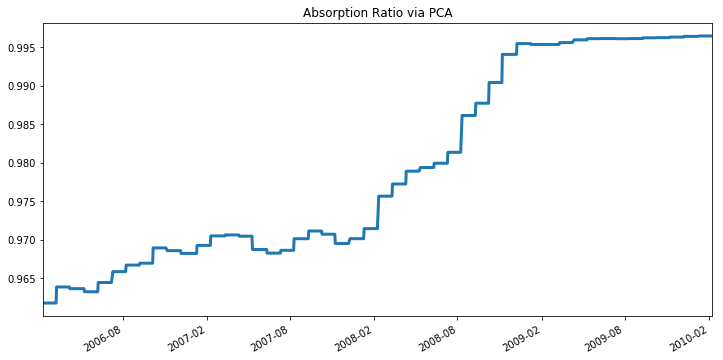

In [26]:
ts_absorb_ratio.plot(figsize=(12,6), title='Absorption Ratio via PCA', linewidth=3)
plt.savefig("Absorption_Ratio_SPX.png", dpi=900)

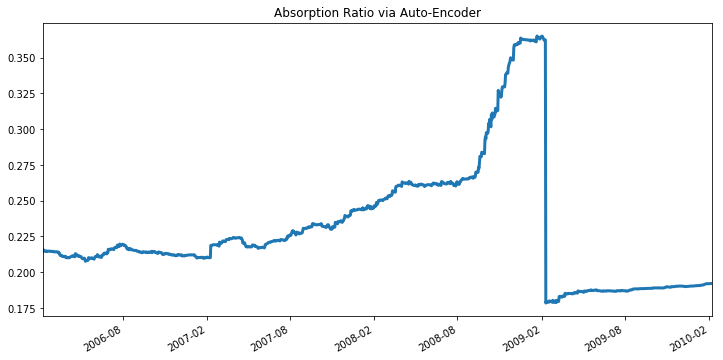

In [27]:
ts_lae_absorb_ratio.plot(figsize=(12,6), title='Absorption Ratio via Auto-Encoder', linewidth=3)

Having computed daily (this means the step size is 1) Absorption Ratio times series, we further follow M. Kritzman to make use of AR to define yet another measure: AR Delta. In particular:
$$ AR\delta = \frac{AR_{15d} - AR_{1y}}{ AR\sigma_{1y}}$$
We use  $AR\delta$ to build simple portfolio trading strategy

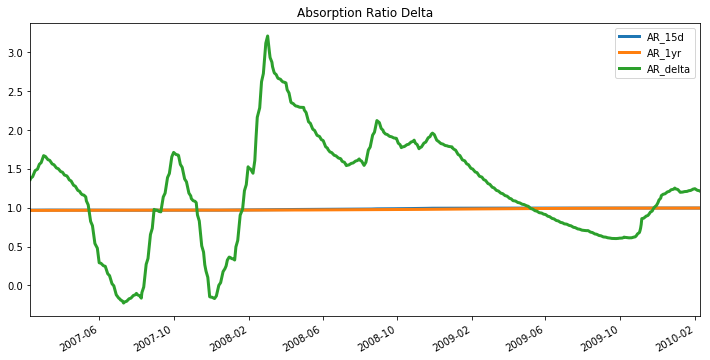

In [28]:
# following Kritzman and computing AR_delta = (15d_AR -1yr_AR) / sigma_AR
ts_ar = ts_absorb_ratio
ar_mean_1yr = ts_ar.rolling(252).mean()
ar_mean_15d = ts_ar.rolling(15).mean()
ar_sd_1yr = ts_ar.rolling(252).std()
ar_delta = (ar_mean_15d - ar_mean_1yr) / ar_sd_1yr    # standardized shift in absorption ratio

df_plot = pd.DataFrame({'AR_delta': ar_delta.values, 'AR_1yr': ar_mean_1yr.values, 'AR_15d': ar_mean_15d.values}, 
                       index=ts_ar.index)
df_plot = df_plot.dropna()
if df_plot.shape[0] > 0:
    df_plot.plot(figsize=(12, 6), title='Absorption Ratio Delta', linewidth=3)

#### Part 3 (AR Delta Trading Strategy)

**Instructions:** Implement get_weight() function

The AR Delta trading strategy forms a portfolio of EQ and FI, following these simple rules:

* __$ -1\sigma < AR < +1\sigma $__	 50 / 50 weights for EQ / FI
* __$ AR > +1\sigma $__	             0 / 100 weights for EQ / FI
* __$ AR < -1\sigma $__	             100 / 0 weights for EQ / FI

Here we compute AR Delta strategy weights using data from the same data set. As expected, the average number of trades per year is very low.

In [29]:
def get_weight(ar_delta):
    '''
    Calculate EQ / FI portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta
    
    Return: 
        wgts -- a vector of portfolio weights
    '''
     
    if ar_delta > 1:
        return [0., 1.]
    elif ar_delta < -1:
        return [1., 0.]
    return [0.5, 0.5]

    return wgts


In [30]:
### GRADED PART (DO NOT EDIT) ###
ar_delta_data = ar_delta[251:]

rebal_dates = np.zeros(len(ar_delta_data))
wgts = pd.DataFrame(data=np.zeros((len(ar_delta_data.index), 2)), index=ar_delta_data.index, columns=('EQ', 'FI'))

prtf_wgts = get_weight(ar_delta_data.values[0])
wgts.iloc[0, :] = prtf_wgts
for ix in range(1, len(ar_delta_data)):
    prtf_wgts = get_weight(ar_delta_data.values[ix])
    wgts.iloc[ix, :] = prtf_wgts
    if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:
        prtf_wgts = wgts.iloc[ix, :]
        rebal_dates[ix] = 1

ts_rebal_dates = pd.Series(rebal_dates, index=ar_delta_data.index)
ts_trades_per_year = ts_rebal_dates.groupby([ts_rebal_dates.index.year]).sum()
print('Average number of trades per year %.2f' % ts_trades_per_year.mean())
### GRADED PART (DO NOT EDIT) ###

Average number of trades per year 1.50


In [31]:
### GRADED PART (DO NOT EDIT) ###
np.random.seed(42)
wgts_test = wgts.as_matrix()
idx_row = np.random.randint(low=0, high=wgts_test.shape[0], size=100)
np.random.seed(42)
idx_col = np.random.randint(low=0, high=wgts_test.shape[1], size=100)

# grading
part_3=list(wgts_test[idx_row, idx_col])
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)

wgts_test[idx_row, idx_col]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([ 0.5,  1. ,  0. ,  0.5,  0.5,  0.5,  0. ,  0.5,  0.5,  1. ,  0.5,
        0. ,  0. ,  0.5,  1. ,  0.5,  0.5,  0.5,  0.5,  0. ,  1. ,  0. ,
        1. ,  1. ,  0.5,  1. ,  1. ,  1. ,  1. ,  1. ,  0. ,  0. ,  1. ,
        1. ,  1. ,  0. ,  0.5,  0. ,  0.5,  0. ,  0.5,  0. ,  0.5,  1. ,
        1. ,  0.5,  1. ,  0.5,  1. ,  1. ,  0. ,  1. ,  0.5,  1. ,  0. ,
        1. ,  1. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,
        0.5,  0. ,  1. ,  1. ,  1. ,  0.5,  0.5,  1. ,  0.5,  1. ,  1. ,
        1. ,  0. ,  0.5,  0. ,  1. ,  0. ,  1. ,  0. ,  0. ,  0.5,  0. ,
        1. ,  1. ,  1. ,  1. ,  1. ,  0.5,  1. ,  1. ,  1. ,  1. ,  1. ,
        0. ])

Now that weights have been determined, run the re-balancing strategy using time series of returns and compute
 - sharpe of the strategy
 - strategy annualized return
 - strategy annualized volatility

Contrast this with 50 / 50 Equity / Fixed Income ETF strategy performance using the same performance metrics. Use VTI as Equity and AGG as Fixed Income assets.

In [32]:
etf_r= pd.read_csv('/home/jovyan/work/readonly/pca_hw5_etf_returns.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0)
etf_prices = pd.read_csv('/home/jovyan/work/readonly/millenials_portfolio_etfs.csv',
                         date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                         index_col = 0)
etf_returns = etf_prices.pct_change(periods=1)
etf_returns = etf_returns.iloc[1450:, :]
etf_r.head()

,VTI,AGG
Index,,
2003-09-29,0.005862,-0.002734
2003-09-30,-0.006036,0.005188
2003-10-01,0.020000,-0.000486
2003-10-02,0.004516,-0.001560
2003-10-03,0.010935,-0.007219


#### Part 4 (Calculate performance of backtested strategy)

**Instructions:**

Implement function backtest_strategy which given a DataFrame of strategy weights and a DataFrame asset returns annualized return, volatility and Sharpe ratio of a strategy.

In [33]:
# GRADED FUNCTION: backtest_strategy
def backtest_strategy(strat_wgts, asset_returns, periods_per_year = 252):
    '''
    Calculate portfolio returns and return portfolio strategy performance
    Arguments:
    
    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year
    
    Return: 
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    '''

    df_ = strat_wgts.join(asset_returns)
    df_['EQ_returns'] = df_['EQ'] * df_['VTI']
    df_['FI_returns'] = df_['FI'] * df_['AGG']
    annualized_return = (df_['EQ_returns'].mean() + df_['FI_returns'].mean()) * periods_per_year
    annualized_vol = (df_['EQ_returns'] + df_['FI_returns']).std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_vol
    return annualized_return, annualized_vol, sharpe_ratio
    # return 0., 0., 1. # annualized return,  annualized volatility,  sharp ratio


In [34]:
### GRADED PART (DO NOT EDIT) ###
ann_ret, ann_vol, sharpe = backtest_strategy(wgts, etf_r)
print('Absorption Ratio strategy:', ann_ret, ann_vol, sharpe)

eq_wgts = wgts.copy()
eq_wgts.iloc[:, ] = 0.5
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_r)
print('Equally weighted:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)
### GRADED PART (DO NOT EDIT) ###

Absorption Ratio strategy: 0.0562078104831 0.0932706438441 0.602631312131
Equally weighted: 0.0159345745095 0.151485012475 0.105189115735
